In [1]:
%matplotlib widget

import sys
import os.path as op
from glob import glob

import numpy as np
from scipy.io import loadmat
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import mne
from mne.io import read_epochs_eeglab
from mne.decoding import SSD
from mne.time_frequency import psd_array_multitaper

from sklearn import svm

In [11]:
def fit_ssd(data, info):
    """Alpha-band Spatio-Spectral Decomposition (SSD) from raw data"""
    #freqs_sig = 9, 14  # alpha
    #freqs_noise = 8, 15  # alpha
    freqs_sig = 15, 29  # beta
    freqs_noise = 14, 30  # beta
    # freqs_sig = 35, 45  # gamma
    # freqs_noise = 30, 50  # gamma

    ssd = SSD(info=info,
              reg='oas',
              sort_by_spectral_ratio=True,
              filt_params_signal=dict(l_freq=freqs_sig[0],
                                      h_freq=freqs_sig[1],
                                      l_trans_bandwidth=1,
                                      h_trans_bandwidth=1),
              filt_params_noise=dict(l_freq=freqs_noise[0],
                                     h_freq=freqs_noise[1],
                                     l_trans_bandwidth=1,
                                     h_trans_bandwidth=1))
    data_filtered = ssd.fit_transform(X=data)
    return data_filtered, ssd


def read_data(subj_id, series_num, data_dir, pick_channels=None):
    # read in both pre- and post-TMS sessions belonging to a single subject
    series_num = str(series_num)
    subj_id = subj_id.zfill(4)
    fname_t1 = op.join(data_dir, 'series_' + series_num, 'T1/preprocessed',
                       subj_id + '_Pre_Session1_Series' + series_num + '_Preprocessed.set')
    fname_t2 = op.join(data_dir, 'series_' + series_num, 'T2/preprocessed',
                       subj_id + '_Post_Session1_Series' + series_num + '_Preprocessed.set')

    # read in data
    epochs_pre_post = list()
    for fname in [fname_t1, fname_t2]:
        epochs = read_epochs_eeglab(fname)
        if pick_channels is not None:
            epochs = epochs.pick_channels(pick_channels)
        epochs_data = epochs.get_data().squeeze()
        #epochs_data -= np.mean(epochs_data, axis=(1, 2), keepdims=True)
        #epochs_data /= np.std(epochs_data, axis=(1, 2), keepdims=True)
        epochs_pre_post.append(epochs_data)
    epochs_info = epochs.info  # save for fit_ssd()
    epoch_times = epochs.times  # save save for spec_event_coherence_shift()
    
    return epochs_pre_post, epochs_info, epoch_times


def spatio_spectral_shift(epochs_pre_post, epochs_info):
    ssd_weights = list()
    for sess_idx, epochs_data in enumerate(epochs_pre_post):
        filtered_data, ssd = fit_ssd(epochs_data, epochs_info)
        ssd_weights.append(ssd.patterns_[0])
    
    # compute stats across pre/post sessions
    ssd_std_diff = ssd_weights[1].std() - ssd_weights[0].std()
    ssd_weights_diff = ssd_weights[1] - ssd_weights[0]
    ssd_weights_diff_flip = ssd_weights[1] + ssd_weights[0]
    # note that some subjects have sessions where the spatial SSD pattern
    # remains consistent, but with opposite sign
    # given that an opposite sign of an SSD weight reflects a pi-radians phase
    # difference, here I explored the possibility that the sign assigned to a
    # given SSD vector is somewhat arbitrary by taking the SSD weight
    # difference with minimal magnitude
    ssd_norm = min(np.sqrt(np.mean(ssd_weights_diff ** 2)),
                   np.sqrt(np.mean(ssd_weights_diff_flip ** 2)))

    return ssd_std_diff, ssd_norm


def spec_event_coherence_shift(epochs_pre_post, times):
    # set path to SpectralEvents
    sys.path.append('/users/rthorpe/brainstorm-ws/spectral-events')
    import spectralevents as se
    
    event_band = [15, 29]  # beta band (Hz)
    thresh_FOM = 6.0  # factor-of-the-median threshold

    dt = times[1] - times[0]
    samp_freq = 1 / dt
    freqs = freqs = range(3, 40)
    
    time_bin = 0.025  # 25 ms
    binned_times = np.arange(0, times[-1] + time_bin, time_bin)
    n_bins = len(binned_times)
    
    pre_post_coherence = list()
    for epochs_data in epochs_pre_post:
        n_epochs = epochs_data.shape[0]
        n_chans = epochs_data.shape[1]
        event_raster = list()
        for chan_idx in range(n_chans):
            chan_events = np.zeros((n_epochs, n_bins))  # to store binary event flags
            chan_epochs_data = epochs_data[:, chan_idx, :].squeeze()
            
            # compute TFRs
            tfrs = se.tfr(chan_epochs_data, freqs, samp_freq)
            # find events
            spec_events = se.find_events(tfr=tfrs, times=times, freqs=freqs,
                                         event_band=event_band, threshold_FOM=6.)
            
            n_events = [len(epoch_events) for epoch_events in spec_events]
            print(f'Found {sum(n_events)} beta events in current channel.')
            for epoch_idx, epoch_events in enumerate(spec_events):
                for event in epoch_events:
                    bin_idx = np.nonzero(binned_times > event['Peak Time'])[0][0]
                    chan_events[epoch_idx, bin_idx] = 1
            event_raster.append(chan_events)
            
            # sanity check: plot event_raster
            #plt.figure()
            #plt.pcolormesh(binned_times, np.arange(n_epochs), chan_events)
            
        event_intersection = event_raster[0] * event_raster[1]
        event_union = ((event_raster[0] + event_raster[1]) > 0).astype(int)
        sess_coherence = event_intersection.mean() / event_union.mean()
        
        print(f'Mean inter-hemisphere beta event coherence for current session: {sess_coherence}!!!')
        pre_post_coherence.append(sess_coherence)
    
    return pre_post_coherence[1] - pre_post_coherence[0]


def get_features(subj_id, series_num, data_dir):
    epochs_pre_post, epochs_info, _ = read_data(subj_id, series_num, data_dir)
    ssd_std_diff, ssd_norm = spatio_spectral_shift(epochs_pre_post, epochs_info)
    
    epochs_pre_post_c3_c4, _, times = read_data(subj_id, series_num, data_dir, pick_channels=['C3', 'C4'])
    spec_event_coherence_diff = spec_event_coherence_shift(epochs_pre_post_c3_c4, times)
    
    return ssd_std_diff, ssd_norm, spec_event_coherence_diff

In [12]:
# set data directory
data_dir = '/gpfs/data/brainstorm-ws/data/'
data_type = 'TRAINING'

In [4]:
# read metadata from master list
fname_master = op.join(data_dir, data_type, data_type + '_Master List_All Series.csv')
master_keys = np.loadtxt(fname_master,  delimiter=',', max_rows=1, dtype=str)
master_keys[0] = 'TMSID'  # fix first key string
master_values = np.loadtxt(fname_master, delimiter=',', skiprows=1, dtype=str)
master_info = {key: master_values[:, master_keys == key].squeeze() for key in master_keys}

# get subject IDs for subject series with both pre-/post-TMS EEG recordings
subj_select = master_info['HasT1T2'] == '1'
subj_ids = master_info['TMSID'][subj_select]
n_series_recordings = sum(subj_select)

In [5]:
# read metadata from demographics and clinical outcomes
fname_outcomes = op.join(data_dir, data_type, data_type + '_Demographics and Clinical Outcomes_All Series.csv')
outcomes_keys = np.loadtxt(fname_outcomes,  delimiter=',', max_rows=1, dtype=str)
outcomes_keys[0] = 'TMSID'  # fix first key string
outcomes_values = np.loadtxt(fname_outcomes, delimiter=',', skiprows=1, dtype=str)
outcome_info = {key: outcomes_values[:, outcomes_keys == key].squeeze() for key in outcomes_keys}

# get demographic and outcome data for each subject series
ages = outcome_info['AgeTMSstart'][subj_select].astype(int)
sexes = outcome_info['Sex'][subj_select].astype(int)
depression_histories = outcome_info['SevHxDep'][subj_select].astype(int)
responders = outcome_info['LastRespIDSSR'][subj_select].astype(int)

# get series number for each subject series
series_nums = outcome_info['Series'][subj_select].astype(int)

In [6]:
# test analysis pipeline
#data_type_dir = op.join(data_dir, data_type)
#ssd_std_diff, ssd_norm, spec_event_coherence_diff = get_features(subj_ids[0], series_nums[0], data_type_dir)

In [13]:
# run spatio-spectral decomposition analysis
# use embarrassingly parallel loop across subject series to speed things up
n_jobs = 12
data_type_dir = op.join(data_dir, data_type)
out = Parallel(n_jobs=n_jobs)(delayed(get_features)(subj_ids[idx], series_nums[idx], data_type_dir)
                              for idx in range(n_series_recordings))
ssd_std_diffs, ssd_norms, spec_event_coherence_diffs = zip(*out)

Found 264 beta events in current channel.
Found 286 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.04627766599597585!!!
Found 415 beta events in current channel.
Found 436 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.08498583569405098!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0192_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 325 beta events in current channel.
Found 299 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03460837887067396!!!
Found 313 beta events in current channel.
Found 286 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.043151969981238276!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING

Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- U

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 7104 out of 7104 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 7104 out of 7104 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 H

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6208 out of 6208 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6208 out of 6208 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  

    Using tolerance 8.3e-13 (2.2e-16 eps * 64 dim * 58  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Done.
Effective window size : 1.000 (s)
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Ha

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4736 out of 4736 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4736 out of 4736 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 H

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Effective window size : 1.000 (s)
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Effective window size : 1.000 (s)
    Using tolerance 3.8e-12 (2.2e-16 eps * 64 dim * 2.7e+02  max singular value)
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
    Using tolerance 1.6e-12 (2.2e-

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0192_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0192_Post_Session1_Series3_Preprocessed.set...
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Using tolerance 4.8e-12 (2.2e-16 eps * 64 dim * 3.4e+02  max singular value)
Computing rank from data with rank=None
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with

Done.
    Using tolerance 1.9e-12 (2.2e-16 eps * 64 dim * 1.3e+02  max singular value)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0116_Post_Session1_Series3_Preprocessed.set...
Not setting metadata
72 matching events found
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
No baseline correction applied
0 projection items activated
Ready.
Effective window size : 1.000 (s)
Found 96 beta events in current channel.
Found 99 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.027624309392265192!!!
Found 370 beta events in current channel.
Found 384 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03407407407407407!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0265_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
76 matching events found
    Using

Not setting metadata
86 matching events found
Computing rank from data with rank=None
No baseline correction applied
0 projection items activated
Ready.
Done.
Reducing data rank from 64 -> 64
Effective window size : 1.000 (s)
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5.9e-12 (2.2e-16 eps * 64 dim * 4.2e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0167_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
96 matching events found
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4544 out of 4544 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4544 out of 4544 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0274_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
103 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Using tolerance 5.8e-12 (2.2e-16 eps * 64 dim * 4.1e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Found 213 beta events in current channel.
Found 2

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fir

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5248 out of 5248 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5248 out of 5248 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  

Done.
Done.
Computing rank from data with rank=None
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
    Using tolerance 6e-12 (2.2e-16 eps * 64 dim * 4.2e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank=None
Done.
Computing rank from data with rank=None
Found 234 beta events in current channel.
Found 234 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03409090909090909!!!
Found 245 beta events in current channel.
Found 231 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03803131991051454!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0295_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
117 matching events found
No baseline correction applie

    Using tolerance 5.3e-12 (2.2e-16 eps * 64 dim * 3.7e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 2.1e-12 (2.2e-16 eps * 64 dim * 1.4e+02  max singular value)
    Using tolerance 1.7e-12 (2.2e-16 eps * 64 dim * 1.2e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 6.2e-12 (2.2e-16 eps * 64 dim * 4.3e+02  max singular value)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0265_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
76 matching events found
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
No baseline correction applied
0 projection item

    Using tolerance 9.1e-12 (2.2e-16 eps * 64 dim * 6.4e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 2.4e-12 (2.2e-16 eps * 64 dim * 1.7e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0267_Pre_Session1_Series1_Preprocessed.set...
Done.
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.0

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5184 out of 5184 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5184 out of 5184 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Done.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0268_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0268_Post_Session1_Series1_Preprocessed.set...
Computing rank from data with rank=None
Effective window size : 1.000 (s)
Not setti

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5184 out of 5184 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank=None
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Done.
    Using tolerance 1.8e-12 (2.2e-16 eps * 64 dim * 1.2e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Effective window size : 1.000 (s)
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 1.3e-12 (2.2e-16 eps * 64 dim * 94  max singular value)
    Estimated r

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Found 290 beta events in current channel.
Found 279 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.020676691729323307!!!
Found 269 beta events in current channel.
Found 307 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.013011152416356878!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0313_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Using tolerance 1.2e-11 (2.2e-16 eps * 64 dim * 8.2e+02  max singular value)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0313_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
81 matching events found
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6272 out of 6272 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    

Found 521 beta events in current channel.
Found 503 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.029787234042553193!!!
Found 296 beta events in current channel.
Found 345 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03523489932885906!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0320_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
91 matching events found
    Using tolerance 5.3e-12 (2.2e-16 eps * 64 dim * 3.7e+02  max singular value)
No baseline correction applied
0 projection items activated
Ready.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0320_Post_Session1_Series2_Preprocessed.set...
Not setting metadata
94 matching events found
No baseline correction applied
0 projection ite

    Using tolerance 1.3e-11 (2.2e-16 eps * 64 dim * 9.1e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 7.2e-12 (2.2e-16 eps * 64 dim * 5.1e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition 

No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0332_Post_Session1_Series1_Preprocessed.set...
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0302_Post_Session1_Series1_Preprocessed.set...
Done.
Not setting metadata
91 matching events found
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Ready.
No baseline correction applied
0 projection items activated
Ready.
Computing rank from data with rank=None
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper pa

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Computing rank from data with rank=None
    Using tolerance 3.6e-12 (2.2e-16 eps * 64 dim * 2.5e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
    Using tolerance 7.7e-12 (2.2e-16 eps * 64 dim * 5.4e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating c

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Done.
Effective window size : 1.000 (s)
Ready.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Effective window size : 1.000 (s)
Done.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0317_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0317_Post_Session1_Series1_Preprocessed.set...
Effective window size : 1.000 (s)
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4800 out of 4800 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0346_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
137 matching events found
    Using tolerance 7.6e-13 (2.2e-16 eps * 64 dim * 54  max singular value)
Found 327 beta events in current channel.
Found 327 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.035175879396984924!!!
Found 308 beta events in current channel.
Found 266 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.044401544401544396!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0348_Pre_Session1_Series1_Preprocessed.set...
No baseline correction applied
Not setting metadata
0 projection items activated
114 matching events found
Ready.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Setting up band-pass filter from 15 - 29 Hz

FIR 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4608 out of 4608 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0348_Post_Session1_Series1_Preprocessed.set...
Reducing data rank from 64 -> 64
Not setting metadata
94 matching events found
Estimating covariance using OAS
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Done.
Effective window size : 1.000 (s)
Computing rank from data with rank=None
    Using tolerance 2.4e-12 (2.2e-16 eps * 64 dim * 1.7e+02  max singular value)


Done.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Effective window size : 1.000 (s)
    Using tolerance 2e-12 (2.2e-16 eps * 64 dim * 1.4e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 6.6e-12 (2.2e-16 eps * 64 dim * 4.6e+02  max singular value)
Done.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Effective window size : 1.000 (s)
    Using tolerance 3.6e-12 (2.2e-16 eps * 64 dim * 2.5e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Done.
Done.
Computing rank from data with rank=None
Effective window size : 1.000 (s)
Computing rank from data with rank=None
Se

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4352 out of 4352 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank=None
Done.
Computing rank from data with rank=None
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0332_Pre_Session1_Series1_Preprocessed.set...
    Using tolerance 6.7e-12 (2.2e-16 eps * 64 dim * 4.7e+02  max singular value)
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0332_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Using tolerance 6.3e-12 (2.2e-16 eps * 64 dim * 4.5e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 project

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5184 out of 5184 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0357_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Done.
Found 357 beta events in current channel.
Found 391 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.04431314623338257!!!
Found 303 beta events in current channel.
Found 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6464 out of 6464 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    

No baseline correction applied
0 projection items activated
Ready.
Effective window size : 1.000 (s)
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Found 481 beta events in current channel.
Found 504 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03854625550660793!!!
Found 409 beta events in current channel.
Found 368 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03194444444444444!!!
Extracting parameters from /gpfs/d

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5056 out of 5056 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0364_Post_Session1_Series2_Preprocessed.set...
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Done.
Effective window size : 1.000 (s)
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firw

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6144 out of 6144 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    

Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Effective window size : 1.000 (s)
Computing rank from data with rank=None
    Using tolerance 4.8e-12 (2.2e-16 eps * 64 dim * 3.4e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 8.5e-12 (2.2e-16 eps * 64 dim * 6e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0

Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Effective window size : 1.000 (s)
    Using tolerance 2.2e-12 (2.2e-16 eps * 64 dim * 1.6e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
    Using tolerance 2.4e-12 (2.2e-16 eps * 64 dim * 1.7e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covaria

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Effective window size : 1.000 (s)
Reducing data rank from 64 -> 64


/tmp/ipykernel_193200/3733526615.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4736 out of 4736 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    

Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 7.9e-12 (2.2e-16 eps * 64 dim * 5.6e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank=None
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-12 (2.2e-16 eps * 64 dim * 1.1e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Up

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4736 out of 4736 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    

No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- U

    Using tolerance 5.8e-12 (2.2e-16 eps * 64 dim * 4.1e+02  max singular value)
Estimating covariance using OAS
Not setting metadata
123 matching events found
Not setting metadata
99 matching events found
No baseline correction applied
No baseline correction applied
0 projection items activated
0 projection items activated
Ready.
Ready.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Done.
    Using tolerance 8e-12 (2.2e-16 e

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6784 out of 6784 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    

No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Using tolerance 3e-12 (2.2e-16 eps * 64 dim * 2.1e+02  max singular value)
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth:

Done.
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 5.7e-12 (2.2e-16 eps * 64 dim * 4e+02  max singular value)
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Done.
Estimating covariance using OAS
Computing rank from data with rank=None
Done.
Computing rank from data with rank=None
Setting up band-pass filter from 14

Done.
Computing rank from data with rank=None
Computing rank from data with rank=None
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Using tolerance 3.1e-12 (2.2e-16 eps * 64 dim * 2.2e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 1.2e-11 (2.2e-16 eps * 64 dim * 8.2e+02  max singular value)
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal 

/tmp/ipykernel_193200/3733526615.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5120 out of 5120 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Done.
Computing rank from data with rank=None
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5952 out of 5952 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    

Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0372_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0372_Post_Session1_Seri

Effective window size : 1.000 (s)
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0370_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
107 matching events found
No baseline correction applied
0 projection items activated
Ready.
Done.
    Using tolerance 2.1e-12 (2.2e-16 eps * 64 dim * 1.5e+02  max singular value)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0370_Post_Session1_Series1_Preprocessed.set...
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated
Ready.
Effective window size : 1.000 (s)
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
    Using tolerance 1.4e-12 (2.2e-16 eps * 64 dim * 95  max singular value)
    Estimated rank (eeg): 64
    EE

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0376_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0376_Post_Session1_Series1_Preprocessed.set...
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
Not setting metadata
- Upper passband edge: 30.00 Hz
99 matching events found
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

No baseline correction applied
0 projection

Found 594 beta events in current channel.
Found 481 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03172978505629478!!!
Found 499 beta events in current channel.
Found 454 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.02142051860202931!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0407_Pre_Session1_Series1_Preprocessed.set...
Computing rank from data with rank=None
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
-

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0413_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Using tolerance 2e-12 (2.2e-16 eps * 64 dim * 1.4e+02  max singular value)
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filt

/tmp/ipykernel_193200/3733526615.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6848 out of 6848 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    

    Using tolerance 7.8e-12 (2.2e-16 eps * 64 dim * 5.5e+02  max singular value)
    Using tolerance 2.2e-12 (2.2e-16 eps * 64 dim * 1.5e+02  max singular value)
Found 431 beta events in current channel.
Found 439 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03508771929824562!!!
Found 437 beta events in current channel.
Found 427 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.049032258064516124!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0416_Pre_Session1_Series1_Preprocessed.set...
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Not setting metadata
83 matching events found
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
No baseline correction applied
0 projection items activated
Ready.
    Using tolerance 9.6e-12 (2.2e-16 eps * 64 dim * 6.8

Done.
Computing rank from data with rank=None
Done.
    Using tolerance 2.5e-12 (2.2e-16 eps * 64 dim * 1.8e+02  max singular value)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design 

Done.
Effective window size : 1.000 (s)
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 2.1e-12 (2.2e-16 eps * 64 dim * 1.5e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 1.3e-12 (2.2e-16 eps * 64 dim * 90  max singular value)
    Estimated rank (eeg): 64
    EEG: ra

/tmp/ipykernel_193200/3733526615.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 8576 out of 8576 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    

Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 H

Done.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0421_Post_Session1_Series3_Preprocessed.set...
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

/tmp/ipykernel_193200/3733526615.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 7296 out of 7296 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Done.
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
Computing rank from data with rank=None
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fir

/tmp/ipykernel_193200/3733526615.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 7424 out of 7424 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0413_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
97 matching events found
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

No baseline correction applied
0 projection items activated
Ready.
    Using tolerance 1.9e-12 (2.2e-16 eps * 64 dim * 1.3e+02  max singular value)
    Using tolerance 3.1e-12 (2.2e-16 eps * 64 dim * 2.2e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 d

Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Using tolerance 2e-12 (2.2e-16 eps * 64 dim * 1.4e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
    Using tolerance 2.3e-12 (2.2e-16 eps * 64 dim * 1.6e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 2.2e-12 (2.2e-16 eps * 64 dim * 1.5e+02  max singular value)
Reduci

/tmp/ipykernel_193200/3733526615.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 7744 out of 7744 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    

Effective window size : 1.000 (s)
Done.
Effective window size : 1.000 (s)
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Using tolerance 4.7e-12 (2.2e-16 eps * 64 dim * 3.3e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-

Found 398 beta events in current channel.
Found 447 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.021518987341772152!!!
Found 326 beta events in current channel.
Found 394 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03731343283582089!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0437_Pre_Session1_Series1_Preprocessed.set...
Reducing data rank from 64 -> 64
Not setting metadata
83 matching events found
Estimating covariance using OAS
Reducing data rank from 64 -> 64
No baseline correction applied
0 projection items activated
Ready.
Estimating covariance using OAS
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0437_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Ready.
Done.
Setting up band-pass

/tmp/ipykernel_193200/3733526615.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5440 out of 5440 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
Effective window size : 1.000 (s)
Reducing data rank from 64 -> 64
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)



/tmp/ipykernel_193200/3733526615.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5184 out of 5184 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    

Estimating covariance using OAS
    Using tolerance 2.9e-12 (2.2e-16 eps * 64 dim * 2e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
Effective window size : 1.000 (s)
Reducing data rank from 64 -> 64
    Using tolerance 1.8e-12 (2.2e-16 eps * 64 dim * 1.2e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
Done.
Effective window size : 1.000 (s)
Computing rank from data with rank=None
Computing rank from data with rank=None
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower p

Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
    Using tolerance 2e-12 (2.2e-16 eps * 64 dim * 1.4e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 1.9e-12 (2.2e-16 eps * 64 dim * 1.4e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
Reducing data rank from 64 -> 64
Effective window size : 1.000 (s)
Estimating covariance using OAS
    Using tolerance 1.2e-12 (2.2e-16 eps * 64 dim * 86  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0421_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items ac

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
/tmp/ipykernel_193200/3733526615.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_193200/3733526615.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_193200/3733526615.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_193200/3733526615.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Paralle

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 H

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upp

Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Estimating covariance using OAS
Reducing data rank from 64 -> 64
Done.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Estimating covariance using OAS
Computing rank from data with rank=None
Done.
Done.
    Using tolerance 2e-12 (2.2e-16 eps * 64 dim * 1.4e+02  max singular value)
Effective window size : 1.000 (s)
Done.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Found 239 beta events in current channel.
F

No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0436_Post_Session1_Series2_Preprocessed.set...
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Using tolerance 4.8e-12 (2.2e-16 eps * 64 dim * 3.4e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 5.5e-12 (2.2e-16 eps * 64 dim * 3.9e+02  max singular value)
Reducing data rank from 64 -> 64
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Estimating covariance using OAS
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband atte

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
/tmp/ipykernel_193200/3733526615.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_193200/3733526615.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_193200/3733526615.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_193200/3733526615.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Paralle

Done.
Computing rank from data with rank=None
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-12 (2.2e-16 eps * 64 dim * 1.3e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass f

Done.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank=None
Found 448 beta events in current channel.
Found 448 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.028985507246376812!!!
Found 456 beta events in current channel.
Found 418 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03735990037359901!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/9001_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Ready.
Done.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/9001_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
76 matching events found
Computing rank from data with rank=None
No baseline correction applied
0 projection items activated
Ready.

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0440_Pre_Session1_Series1_Preprocessed.set...
Computing rank from data with rank=None
Not setting metadata
111 matching events found
Reducing data rank from 64 -> 64
No baseline correction applied
0 projection items activated
Ready.
Estimating covariance using OAS
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0440_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
81 matching events found
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0467_Pre_Session1_Series1_Preprocessed.set...
No baseline correction applied
0 projection items activated
Ready.
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Ready.
Done.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0467_Post_Session1_Series1_Preprocessed.set...

/tmp/ipykernel_193200/3733526615.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5568 out of 5568 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Using tolerance 8.3e-12 (2.2e-16 eps * 64 dim * 5.8e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0469_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
76 matching events found
Reducing data rank from 64 -> 64
No baseline correction applied
0 projection items activated
Ready.
Estimating covaria

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0472_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
115 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0472_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Ready.
Computing rank from data with rank=None
    Using tolerance 5.4e-12 (2.2e-16 eps * 64 dim * 3.8e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 6e-12 (2.2e-16 eps * 64 dim * 4.2e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Estimating

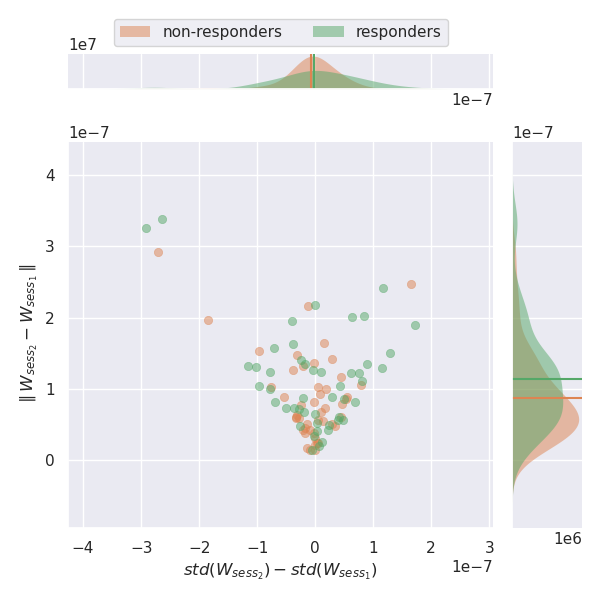

In [14]:
g = sns.JointGrid()

for class_idx, class_ in enumerate(set(responders)):
    if class_ == 1:
        label = 'responders'
    else:
        label = 'non-responders'
    cluster_mask = responders == class_
    x = np.array(ssd_std_diffs)[cluster_mask]
    y = np.array(ssd_norms)[cluster_mask]
    
    # plot data points for a given class label (i.e., responder or non-responder)
    sns.scatterplot(x=x, y=y, alpha=.5, edgecolor=None,
                    color=f'C{class_idx + 1}', ax=g.ax_joint)
    
    # plot marginal distributions for a given class label
    sns.kdeplot(x=x, bw_adjust=0.85, fill=True, linewidth=0, alpha=.5,
                color=f'C{class_idx + 1}', ax=g.ax_marg_x, label=label)
    g.ax_marg_x.axvline(np.mean(x), color=f'C{class_idx + 1}')
    sns.kdeplot(y=y, bw_adjust=0.85, fill=True, linewidth=0, alpha=.5,
                color=f'C{class_idx + 1}', ax=g.ax_marg_y)
    g.ax_marg_y.axhline(np.mean(y), color=f'C{class_idx + 1}')
    
    
g.ax_joint.set_xlabel(r'$std(W_{sess_2})-std(W_{sess_1})$')
g.ax_joint.set_ylabel(r'$\parallel W_{sess_2}-W_{sess_1}\parallel$')
g.ax_marg_x.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, 1.02))
g.fig.tight_layout()

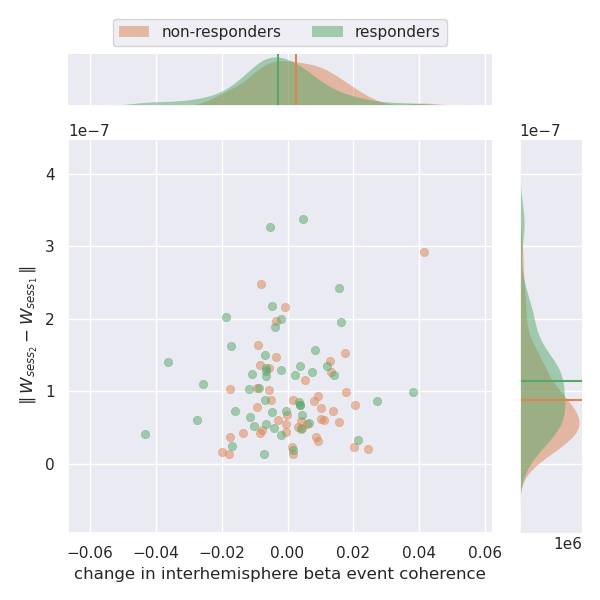

In [15]:
g = sns.JointGrid()

for class_idx, class_ in enumerate(set(responders)):
    if class_ == 1:
        label = 'responders'
    else:
        label = 'non-responders'
    cluster_mask = responders == class_
    x = np.array(spec_event_coherence_diffs)[cluster_mask]
    y = np.array(ssd_norms)[cluster_mask]
    
    # plot data points for a given class label (i.e., responder or non-responder)
    sns.scatterplot(x=x, y=y, alpha=.5, edgecolor=None,
                    color=f'C{class_idx + 1}', ax=g.ax_joint)
    
    # plot marginal distributions for a given class label
    sns.kdeplot(x=x, bw_adjust=0.85, fill=True, linewidth=0, alpha=.5,
                color=f'C{class_idx + 1}', ax=g.ax_marg_x, label=label)
    g.ax_marg_x.axvline(np.mean(x), color=f'C{class_idx + 1}')
    sns.kdeplot(y=y, bw_adjust=0.85, fill=True, linewidth=0, alpha=.5,
                color=f'C{class_idx + 1}', ax=g.ax_marg_y)
    g.ax_marg_y.axhline(np.mean(y), color=f'C{class_idx + 1}')
    
    
g.ax_joint.set_xlabel(f'change in interhemisphere beta event coherence')
g.ax_joint.set_ylabel(r'$\parallel W_{sess_2}-W_{sess_1}\parallel$')
g.ax_marg_x.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, 1.02))
g.fig.tight_layout()